# Calibrate Model via Abundance Matching at z=4


In [1]:
# import modules

import numpy as np
from astropy.cosmology import WMAP7 as cosmo
import astropy.units as u
from astropy.table import Table
import h5py
from hmf import MassFunction
import fsps

import make_SFH
import read_in_halo_cat
import derive_SP_prop

import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.serif'] = 'STIXGeneral'


In [2]:
# define paths

path_main = '/Users/sandrotacchella/ASTRO/JWST/Halo_Model/'
path_figures = path_main + 'Figures/'
path_DM_cat = path_main + 'catalogs/DM/'
path_SFH_cat = path_main + 'catalogs/SFH/'
path_SP_cat = path_main + 'catalogs/SP/'


# set SFH option

SFH_type_option = 'constant'


In [3]:
# define functions

def compute_HMF(mass_list, mass_bins, volume_box):
    idx_good = np.isfinite(np.log10(mass_list))
    hist_zX, bin_edges = np.histogram(np.log10(mass_list[idx_good]), bins=mass_bins)
    HMFcum_zX = np.cumsum(hist_zX[::-1])[::-1]/(volume_box)
    return(HMFcum_zX)


def get_analytical_HMF(redshift):
    '''
    PS, Jenkins, SMF, Warren, Tinker08 
    '''
    HMF = MassFunction(cosmo_model=cosmo, z=redshift, Mmin=8, Mmax=15, hmf_model='SMT')
    cumulative_mass_func = HMF.ngtm*cosmo.h**3
    masses = HMF.m/cosmo.h
    return(masses, cumulative_mass_func)





# Construct DM halo mass function

In [4]:
# read in catalog

z_table_z4, M_table_z4, Mt_table_z4 = read_in_halo_cat.read_in_halo_cat(path_DM_cat + 'MergerHistory_COLOR_CDM_z3.96.hdf5', cosmo)




[ 8.    8.05  8.1   8.15  8.2   8.25  8.3   8.35  8.4   8.45  8.5   8.55
  8.6   8.65  8.7   8.75  8.8   8.85  8.9   8.95  9.    9.05  9.1   9.15
  9.2   9.25  9.3   9.35  9.4   9.45  9.5   9.55  9.6   9.65  9.7   9.75
  9.8   9.85  9.9   9.95 10.   10.05 10.1  10.15 10.2  10.25 10.3  10.35
 10.4  10.45 10.5  10.55 10.6  10.65 10.7  10.75 10.8  10.85 10.9  10.95
 11.   11.05 11.1  11.15 11.2  11.25 11.3  11.35 11.4  11.45 11.5  11.55
 11.6  11.65 11.7  11.75 11.8  11.85 11.9  11.95 12.   12.05 12.1  12.15
 12.2  12.25 12.3  12.35 12.4  12.45 12.5  12.55 12.6  12.65 12.7  12.75
 12.8  12.85 12.9  12.95 13.   13.05 13.1  13.15 13.2  13.25 13.3  13.35
 13.4  13.45 13.5 ]


/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in log10


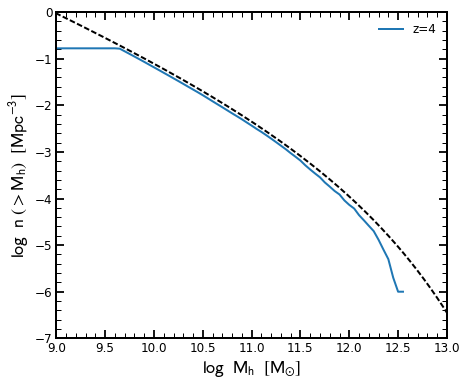

In [5]:
# construct halo mass function

min_mass = 9.0
max_mass = 13.5
volume_box = 100.0**3  # in Mpc^-3

mass_bins = np.linspace(8.0, 13.5, num=111)
print mass_bins
mass_bins_left = mass_bins[:-1]
mass_bins_center = mass_bins[:-1]+0.5*np.diff(mass_bins)

HMF_z4 = compute_HMF(M_table_z4, mass_bins, volume_box)


# get analytical halo mass function

HMF_analytic_z4 = get_analytical_HMF(4.0)


# plot HMF

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))

ax.plot(mass_bins_left, np.log10(HMF_z4), '-', lw=2, label='z=4')
ax.plot(np.log10(HMF_analytic_z4[0]), np.log10(HMF_analytic_z4[1]), '--', color='black', lw=2) 

ax.set_xlabel(r'$\log\/\/\/\/\mathrm{M}_{\rm h}\/\/\/\/[\mathrm{M}_{\odot}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\mathrm{n}\/\/(>\mathrm{M}_{\rm h})\/\/\/\/[\mathrm{Mpc}^{-3}]$', fontsize=18)

ax.set_xlim([9, 13])
ax.set_ylim([-7.0, 0.0])

plt.legend(frameon=False, fontsize=12)
plt.savefig(path_figures + 'Tests/HaloMF_z4.pdf', bbox_inches='tight')
plt.show()



/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


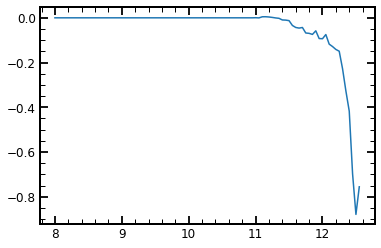

In [6]:
# compute difference, but take out average

difference_HMF = np.log10(HMF_z4)-np.interp(mass_bins_left, np.log10(HMF_analytic_z4[0]), np.log10(HMF_analytic_z4[1]), left=np.nan, right=np.nan)

idx_11 = np.abs(mass_bins_left-11.0).argmin()
difference_HMF -= np.median(difference_HMF[idx_11-5:idx_11+5])
difference_HMF[:idx_11] = 0.0

plt.plot(mass_bins_left, difference_HMF)
plt.show()


# Abundance Matching

Details of abundance matching:

1. Obtain L_UV(Mh, z=4) by abundance matching: n(>Mh) = rho(>LUV), where n is the cumulative halo mass function and rho is the cumulative UV LF.

2. Get epsilon by comparing predicted L_UV(Mh, z=4) from epsilon = 1.0 and L_UV(Mh, z=4) from abundance matching => get distribution function


In [7]:
# define functions

def get_dust_attenuation(magUV_in, redshift_in, with_scatter=False):
    '''
    This function computes the dust attenuation at 1600 A (A1600)
    from the Bouwens et al 2015 relation.
    '''
    # ensure inputs are arrays
    if type(magUV_in) is not np.ndarray:
        magUV_in = np.array([magUV_in])
    if type(redshift_in) is not np.ndarray:
        redshift_in = np.array([redshift_in])
    # values for beta-MUV relation from Bouwens et al 2015
    B15_z_list = np.array([2.5, 3.8, 5.0, 5.9, 7.0, 8.0])
    B15_beta_list = np.array([-1.70, -1.85, -1.91, -2.00, -2.05, -2.13])
    B15_dbdM_list = np.array([-0.20, -0.11, -0.14, -0.20, -0.20, -0.15])
    # interpolate beta-MUV relation
    beta_value = np.interp(redshift_in, B15_z_list, B15_beta_list, left=B15_beta_list[0], right=np.nan)
    dbdM_value = np.interp(redshift_in, B15_z_list, B15_dbdM_list, left=B15_dbdM_list[0], right=np.nan)
    # get average beta
    avg_b = dbdM_value*(magUV_in+19.5) + beta_value
    # convert beta to A1600
    if with_scatter:
        A1600 = 4.43 + 1.99*(avg_b + np.random.normal(loc=0.0, scale=0.34, size=len(avg_b)))
    else:
        A1600 = 4.43 + 0.2*np.log(10)*1.99**2*0.34**2+1.99*avg_b
    A1600[np.isnan(A1600)] = np.zeros(np.sum(np.isnan(A1600)))
    A1600[A1600 < 0.0] = np.zeros(np.sum(A1600 < 0.0))
    return(A1600)


def UV_LF_Bouwens15(mag_in, z, do_dust_corr=True, with_scatter=False):
    '''
    This returns the UV LF (mags and phis) of Bouwens et al 2015.
    '''
    # Bouwens et al 2015
    MUV = -20.95+0.01*(z-6.0)
    phi = 0.47*np.power(10, -0.27*(z-6.0))*10**-3  # in Mpc
    alpha = -1.87-0.1*(z-6.0)
    if do_dust_corr:
        AUV = get_dust_attenuation(mag_in, z, with_scatter=with_scatter)
        mag = mag_in - AUV
    else:
        mag = mag_in
    return(mag, phi*(np.log(10)/2.5)*np.power(10, -0.4*(mag_in-MUV)*(alpha+1.0))*np.exp(-1.0*np.power(10.0, -0.4*(mag_in-MUV))))


def matching(UV_LF, HMF, Mh_list, redshift):
    '''
    This function returns a UV luminosity (at 1600 A) given a dark matter halo mass
    assuming a halo mass function and a UV luminosity function (cumulative).
    '''
    num_density = np.interp(Mh_list, HMF[0], HMF[1], left=np.nan, right=np.nan)
    UV_mag = np.interp(num_density, UV_LF[1], UV_LF[0], left=np.nan, right=np.nan)
    L_1600 = 4*np.pi*(3.086e+19)**2*np.power(10, -0.4*(UV_mag+48.6))  # in order to make it erg/s (instead of Lsun)
    return(L_1600)



/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10


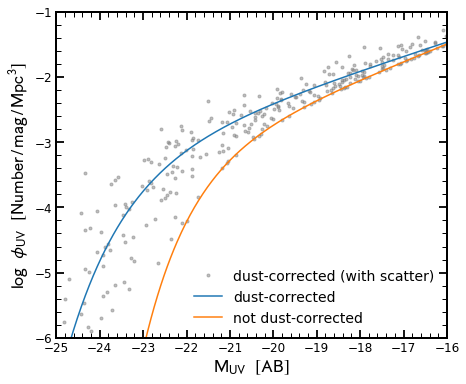

In [8]:
# get luminosity functions (dust and not dust corrected)

list_mag_in = np.linspace(-30.0, -5.0, num=1000)
list_mag, phi_mag = UV_LF_Bouwens15(list_mag_in, 4.0, do_dust_corr=True)
list_mag_wscatter, phi_mag_wscatter = UV_LF_Bouwens15(list_mag_in, 4.0, do_dust_corr=True, with_scatter=True)
list_mag_not_dust_corrected, phi_mag_not_dust_corrected = UV_LF_Bouwens15(list_mag_in, 4.0, do_dust_corr=False)


# plot luminosity functions

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 6))

ax.plot(list_mag_wscatter, np.log10(phi_mag_wscatter), '.', label='dust-corrected (with scatter)', color='gray', alpha=0.5)
ax.plot(list_mag, np.log10(phi_mag), '-', label='dust-corrected')
ax.plot(list_mag_not_dust_corrected, np.log10(phi_mag_not_dust_corrected), '-', label='not dust-corrected')

ax.set_xlabel(r'$\mathrm{M}_{\rm UV}\/\/\/\/[\mathrm{AB}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\phi_{\rm UV}\/\/\/\/[\mathrm{Number}\//\/\mathrm{mag}\//\/\mathrm{Mpc}^{3}]$', fontsize=18)

ax.set_xlim([-25.0, -16])
ax.set_ylim([-6.0, -1.0])


plt.legend(frameon=False, fontsize=14)  
plt.savefig(path_figures + 'Calibration/UV_LF_dustcorrection.pdf', bbox_inches='tight')
plt.show()



/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10


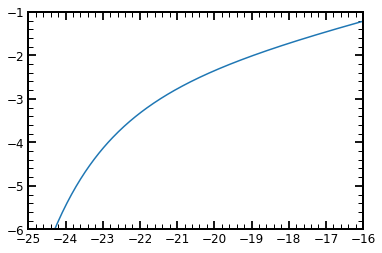

In [9]:
# determine the cumulative UV LF

phi_UV_cum = []

for ii_mag in list_mag:
    idx = (list_mag < ii_mag)
    phi_UV_cum = np.append(phi_UV_cum, np.trapz(phi_mag[idx], list_mag[idx]))


plt.xlim([-25.0, -16])
plt.ylim([-6.0, -1.0])

plt.plot(list_mag, np.log10(phi_UV_cum), '-')
plt.show()



/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


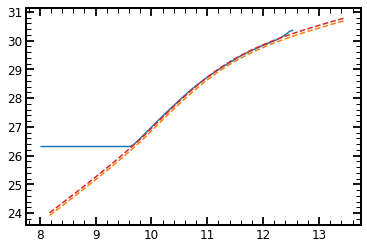

[2.06077826e+26 2.06077826e+26 2.06077826e+26 2.06077826e+26
 2.06077826e+26 2.06077826e+26 2.06077826e+26 2.06077826e+26
 2.06077826e+26 2.06077826e+26 2.06077826e+26 2.06077826e+26
 2.06077826e+26 2.06077826e+26 2.06077826e+26 2.06077826e+26
 2.06077826e+26 2.06077826e+26 2.06077826e+26 2.06077826e+26
 2.06077826e+26 2.06077826e+26 2.06077826e+26 2.06077826e+26
 2.06077826e+26 2.06077826e+26 2.06077826e+26 2.06077826e+26
 2.06077826e+26 2.06077826e+26 2.06077826e+26 2.06077826e+26
 2.09060175e+26 2.35168510e+26 2.89574363e+26 3.57625907e+26
 4.43381888e+26 5.53096378e+26 6.90758001e+26 8.67187572e+26
 1.08588008e+27 1.35828871e+27 1.69644125e+27 2.11457018e+27
 2.63014523e+27 3.26451523e+27 4.04982968e+27 5.00170488e+27
 6.14608389e+27 7.54455324e+27 9.28422456e+27 1.14250123e+28
 1.39706574e+28 1.69534971e+28 2.04882448e+28 2.46541596e+28
 2.94042490e+28 3.48362549e+28 4.13035061e+28 4.88482387e+28
 5.75134249e+28 6.71047642e+28 7.78959174e+28 9.06341824e+28
 1.05198927e+29 1.216856

In [10]:
# do the abundance matching and plot LUV-Mhalo relation

Mh_list = mass_bins_center
LUV_Mh = matching([list_mag, np.log10(phi_UV_cum)], [mass_bins_left, np.log10(HMF_z4)], Mh_list, 4.0)
LUV_Mh2 = matching([list_mag, np.log10(phi_UV_cum)], [np.log10(HMF_analytic_z4[0]), np.log10(HMF_analytic_z4[1])], Mh_list, 4.0)

idx = np.abs(Mh_list-11.0).argmin()
LUV_Mh_renorm = LUV_Mh2*LUV_Mh[idx]/LUV_Mh2[idx]

plt.plot(Mh_list, np.log10(LUV_Mh), '-')
plt.plot(Mh_list, np.log10(LUV_Mh_renorm), '--', color='C3')
plt.plot(Mh_list, np.log10(LUV_Mh2), '--')
plt.show()

print LUV_Mh
print LUV_Mh2



# Determine efficiency epsilon

In [11]:
# read in UV catalog based on epsilon=1.0 run

cat_z4 = h5py.File(path_SP_cat + 'SFH_z4_constant_calibration_with_L.hdf5', 'r')



In [12]:
# determine epsilon: for a given Mh, you should get LUV (as given by LUV_Mh)

# bin epsilon in order to save it

epsilon_bins = np.linspace(-3.0, 5.0, num=501)
epsilon_bin_center = epsilon_bins[:-1] + 0.5*np.diff(epsilon_bins)
epsilon_hist2d = epsilon_bin_center

epsilon_16pers = []
epsilon_median = []
epsilon_84pers = []
epsilon2_16pers = []
epsilon2_median = []
epsilon2_84pers = []

for ii_M in range(len(mass_bins)-1):
    index = (np.log10(cat_z4['DM/DM_M'][:]) >= mass_bins[ii_M]) & (np.log10(cat_z4['DM/DM_M'][:]) < mass_bins[ii_M+1])
    LUV_distribution = cat_z4['luminosities/luminosity_0'][:, 2][index]
    if (np.isnan(LUV_Mh_renorm[ii_M])) | (np.sum(index) == 0.0):
        epsilon_hist2d = np.vstack([epsilon_hist2d, np.nan*np.ones(len(epsilon_bin_center))])
        epsilon_16pers = np.append(epsilon_16pers, np.nan)
        epsilon_median = np.append(epsilon_median, np.nan)
        epsilon_84pers = np.append(epsilon_84pers, np.nan)
        epsilon2_16pers = np.append(epsilon2_16pers, np.nan)
        epsilon2_median = np.append(epsilon2_median, np.nan)
        epsilon2_84pers = np.append(epsilon2_84pers, np.nan)
    else:
        idx = (LUV_distribution > 0.0)
        epsilon_distribution = LUV_Mh_renorm[ii_M]/LUV_distribution[idx]
        hist, bin_edges = np.histogram(np.log10(epsilon_distribution), bins=epsilon_bins, density=True)
        epsilon_hist2d = np.vstack([epsilon_hist2d, hist])
        epsilon_16pers = np.append(epsilon_16pers, np.percentile(epsilon_distribution, 16))
        epsilon_median = np.append(epsilon_median, np.percentile(epsilon_distribution, 50))
        epsilon_84pers = np.append(epsilon_84pers, np.percentile(epsilon_distribution, 84))
        epsilon2_distribution = LUV_Mh2[ii_M]/LUV_distribution[idx]
        epsilon2_16pers = np.append(epsilon2_16pers, np.percentile(epsilon2_distribution, 16))
        epsilon2_median = np.append(epsilon2_median, np.percentile(epsilon2_distribution, 50))
        epsilon2_84pers = np.append(epsilon2_84pers, np.percentile(epsilon2_distribution, 84))



In [13]:
# completeness correction
difference_HMF_epsilon = np.interp(Mh_list, mass_bins_left, difference_HMF, left=np.nan, right=np.nan)

epsilon_median = 10**difference_HMF_epsilon*epsilon_median
epsilon_16pers = 10**difference_HMF_epsilon*epsilon_16pers
epsilon_84pers = 10**difference_HMF_epsilon*epsilon_84pers


In [14]:
# cheap comparison Behroozi

#Mh_Behroozi13 = [2.353e11, 3.210e11, 5.639e11, 7.352e11, 9.748e11, 1.331e12, 1.775e12, 3.135e12, 4.480e12, 6.709e12, 1.082e13, 1.762e13]
#MM_Behroozi13 = [0.007, 0.010, 0.017, 0.020, 0.022, 0.022, 0.021, 0.016, 0.013, 0.009, 0.006, 0.004]



In [15]:
# fit analytically

def double_power_law(log_mass_list, norm, mass_c, beta, gamma):
    '''
    From Moster+2010.
    '''
    return(2*norm*np.power(np.power(np.power(10, log_mass_list)/mass_c, -1.0*beta)+np.power(np.power(10, log_mass_list)/mass_c, gamma), -1.0))   
    

from scipy.optimize import curve_fit
           
    
idx_fit = ~np.isnan(epsilon_median) & (Mh_list > 9.8) & (Mh_list < 12.0)
popt, pcov = curve_fit(double_power_law, Mh_list[idx_fit], epsilon_median[idx_fit], p0=[0.6, 10**11.5, 1.0, 1.0])           
print popt


[5.22698572e-01 1.60823399e+11 9.04964742e-01 4.55804056e-01]


/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


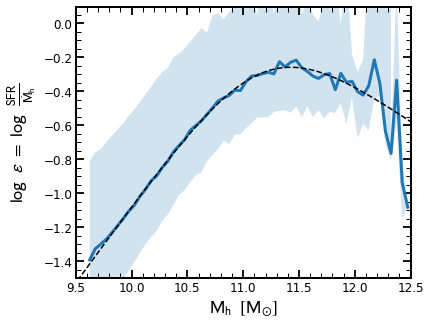

In [16]:
# plot efficiency with fit

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

ax.plot(Mh_list, np.log10(epsilon_median), '-', lw=3)
ax.fill_between(Mh_list, np.log10(epsilon_16pers), np.log10(epsilon_84pers), alpha=0.2)

ax.plot(Mh_list, np.log10(double_power_law(Mh_list, popt[0], popt[1], popt[2], popt[3])), '--', color='black')

ax.set_xlabel(r'$\mathrm{M}_{\rm h}\/\/\/\/[\mathrm{M}_{\odot}]$', fontsize=18)
ax.set_ylabel(r'$\log\/\/\/\/\epsilon\/\/=\/\/\log\/\/\/\/\frac{\rm SFR}{\rm \dot{M}_{\rm h}}$', fontsize=18)

ax.set_xlim([9.5, 12.5])
ax.set_ylim([-1.5, 0.1])

plt.legend(frameon=False, fontsize=14)
plt.savefig(path_figures + 'Calibration/efficency_' + SFH_type_option + '.pdf', bbox_inches='tight')
plt.show()


In [17]:
# re-format epsilon

halo_info = np.append(-1, Mh_list)[np.newaxis]
epsilon_hist2d_complete = np.hstack([halo_info.T, epsilon_hist2d])

# save epsilon

np.save(path_SFH_cat + 'calibration/epsilon_' + SFH_type_option + '.npy', epsilon_hist2d_complete)
np.save(path_SFH_cat + 'calibration/epsilon_' + SFH_type_option + '_median.npy', np.array([Mh_list, np.log10(epsilon_median), np.log10(epsilon_16pers), np.log10(epsilon_84pers)]))
np.save(path_SFH_cat + 'calibration/epsilon2_' + SFH_type_option + '_median.npy', np.array([Mh_list, np.log10(epsilon2_median), np.log10(epsilon2_16pers), np.log10(epsilon2_84pers)]))
np.save(path_SFH_cat + 'calibration/epsilon_' + SFH_type_option + '_param.npy', popt)



/Users/sandrotacchella/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10
